# 케라스 인공 신경망 응용 예제

---------



## 영화 리뷰 예제

이 예제는 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류한다.

데이터: IMDB 데이터셋 - 영화 리뷰 

- 긍정/부정 레이블이 지정되어 있음

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

위에서 ```num_words=10000```은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어만을 선택하여 이용한다는 뜻. 

- 이 데이터셋의 샘플은 전처리된 정수 배열로, 영화 리뷰에 나오는 단어를 숫자로 변환한 것이다.

- 레이블(label), 즉, y값은 정수 0 또는 1로서, 0은 부정적인 리뷰이고 1은 긍정적인 리뷰이다.

In [3]:
# 간단히 y값 확인
train_labels[3]

1

In [4]:
print(f"훈련 샘플: {len(train_data)}, 레이블: {len(train_labels)}")

훈련 샘플: 25000, 레이블: 25000


리뷰 문장은 정수로 표현되어 있다.

In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
len(train_data[0]), len(train_data[1])

(218, 189)

`get_word_index()`는 단어를 정수로 바꿔주는 dictionary를 생성한다.

In [7]:
word_index = imdb.get_word_index() 
word_index["the"], word_index["and"], word_index["a"], word_index["of"], word_index["to"]

(1, 2, 3, 4, 5)

`"<PAD>", "<START>", "<UNK>", "<UNUSED>"`와 같은 특수 문자들을 배정하기 위해, 기존의 dictionary의 값들을 3씩 더하고,

특수문자들의 숫자를 0, 1, 2, 3으로 배정.

In [8]:
# 처음 몇 개 인덱스는 사전에 정의되어 있음.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

아래의 `decode_review()` 함수를 사용하면, 정수 배열에서 문장으로 변환할 수 있다.

In [9]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])   #만약 딕셔너리에 없는 숫자(i)가 있으면 '?'로 대체

In [10]:
decode_review(train_data[3])

"<START> the <UNK> <UNK> at storytelling the traditional sort many years after the event i can still see in my <UNK> eye an elderly lady my friend's mother retelling the battle of <UNK> she makes the characters come alive her passion is that of an eye witness one to the events on the <UNK> heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from the way she tells it the same story is told in bars the length and <UNK> of scotland as i discussed it with a friend one night in <UNK> a local cut in to give his version the discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember the stories our parents told us when we were children they become our invisible world and as we grow older they maybe still serve as inspiration or as an emotional <UNK> fact and fiction blend with <UNK> role models warning stories <UNK> magic and mystery br br my name is <UNK> like my g

In [11]:
len(train_data[3])

550

### 데이터 구성

리뷰(정수 배열)는 신경망에 주입하기 전에 텐서로 변환되어야 한다. 변환하는 방법에는 몇 가지가 있다.

* 원-핫 인코딩(one-hot encoding)은 정수 배열을 0과 1로 이루어진 벡터로 변환한다. 예를 들어 배열 ```[3, 5]```을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있다. 

* 다른 방법으로는, 정수 배열의 길이가 모두 같도록 패딩(padding), 예를 들어 0의 값, 을 추가해 ```num_reviews* max_length``` 크기의 정수 텐서를 만든다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용할 수 있다.

이 예제에서는 두 번째 방식을 사용한다.

In [12]:
train_data = keras.utils.pad_sequences(train_data, value=word_index["<PAD>"],
                                       padding='post')  # post : 뒤에 PAD를 붙이는 방식

test_data = keras.utils.pad_sequences(test_data, value=word_index["<PAD>"],
                                      padding='post')

In [13]:
train_data[3]

array([1, 4, 2, ..., 0, 0, 0])

In [14]:
decode_review(train_data[3])

"<START> the <UNK> <UNK> at storytelling the traditional sort many years after the event i can still see in my <UNK> eye an elderly lady my friend's mother retelling the battle of <UNK> she makes the characters come alive her passion is that of an eye witness one to the events on the <UNK> heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from the way she tells it the same story is told in bars the length and <UNK> of scotland as i discussed it with a friend one night in <UNK> a local cut in to give his version the discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember the stories our parents told us when we were children they become our invisible world and as we grow older they maybe still serve as inspiration or as an emotional <UNK> fact and fiction blend with <UNK> role models warning stories <UNK> magic and mystery br br my name is <UNK> like my g

## 모델

1. 첫 번째 층은 Embedding 층이다. 이 층은 정수로 인코딩된 단어를 입력 받아, 각 단어 인덱스에 해당하는 임베딩 벡터를 찾는다. 임베딩 벡터는 실수로 구성되어 있으며, 단어 간 유사도를 고려하여 생성된다. 

2. 그 다음 GlobalAveragePooling1D 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환한다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법이다.

3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거친다.

4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층으로. sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력한다. 이 값은 확률 또는 신뢰도를 나타낸다.

In [15]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### [`keras.layers.Embedding()`](https://keras.io/api/layers/core_layers/embedding/)

Embedding 층 : 정수 인덱스를 학습 가능한 벡터로 변환한다.

- 이 예제에서는 각 단어의 정수 인덱스가 `output_dim=16`차원의 실수값 벡터로 변환된다.
- 이 벡터값은 처음에는 랜덤값으로 설정된다.
- 학습 과정 중 문맥 상 비슷한 단어끼리 가까워지도록 학습된다.
- Embedding layer의 parameter 행렬의 shape : 단어 사전 크기 $\times$ 임베딩 차원

In [104]:
# example : embedding

x = np.array([[1,2,3,4,5,6,7,8,9,9],
       [3,4,1,6,7,8,9,2,0,0],
       [1,1,2,3,2,2,2,2,1,1]])
              
tf.keras.layers.Embedding(input_dim = 10, output_dim = 2, input_length=10)(x)

<tf.Tensor: shape=(3, 10, 2), dtype=float32, numpy=
array([[[-0.04195602,  0.04548175],
        [ 0.0073735 ,  0.03801725],
        [ 0.0475576 , -0.0265579 ],
        [ 0.02824166,  0.04904347],
        [ 0.02700103, -0.04945821],
        [ 0.00785576,  0.04177264],
        [ 0.02711948, -0.03595161],
        [ 0.01092887,  0.01093785],
        [ 0.00188119, -0.03839679],
        [ 0.00188119, -0.03839679]],

       [[ 0.0475576 , -0.0265579 ],
        [ 0.02824166,  0.04904347],
        [-0.04195602,  0.04548175],
        [ 0.00785576,  0.04177264],
        [ 0.02711948, -0.03595161],
        [ 0.01092887,  0.01093785],
        [ 0.00188119, -0.03839679],
        [ 0.0073735 ,  0.03801725],
        [-0.03705452,  0.01905917],
        [-0.03705452,  0.01905917]],

       [[-0.04195602,  0.04548175],
        [-0.04195602,  0.04548175],
        [ 0.0073735 ,  0.03801725],
        [ 0.0475576 , -0.0265579 ],
        [ 0.0073735 ,  0.03801725],
        [ 0.0073735 ,  0.03801725],
        

In [35]:
# Embedding example
temp_model = tf.keras.Sequential()
temp_model.add(tf.keras.layers.Embedding(input_dim = 1000, output_dim = 64, input_length=10))
input_array = np.random.randint(1000, size=(32, 10))  # batch size, sequence length
input_array

array([[250, 492, 345, 305, 872, 683, 875, 739, 571, 794],
       [759, 740, 270, 160, 710, 389, 984, 999, 989, 256],
       [801,   9, 232, 835, 343, 114, 668, 474, 659, 611],
       [345, 538, 510, 963, 141, 214, 695, 163, 527, 746],
       [845, 120, 435, 541, 147, 183, 113, 564, 383, 219],
       [443,  90, 885, 965,  88, 815, 105, 243, 909, 844],
       [145, 153, 810, 303, 812, 112, 851, 916,  18, 290],
       [470, 366, 517, 487, 143, 347, 260, 895, 174, 377],
       [702, 608, 686, 404, 960, 715, 741, 557, 940, 149],
       [302,  54, 397, 585, 900, 568, 338, 676, 714,  43],
       [184, 233, 399, 595, 813, 732, 437, 340, 877,  30],
       [338, 890, 597, 748,  70, 702, 905, 277, 744, 673],
       [763, 395, 126, 381, 257, 643, 459, 443, 261, 868],
       [411, 940, 842, 917, 180, 319, 868, 439, 851, 278],
       [341, 439, 430,  86, 891, 810, 136, 351, 639, 903],
       [813, 839, 733, 176, 487, 572, 536, 731, 849, 239],
       [438, 723,  29, 735, 182,  52, 171,  67,  14, 575

In [40]:
temp_model.compile('rmsprop', 'mse')
output_array = temp_model.predict(input_array)

1/1 [==============================] - 0s 79ms/step


In [41]:
# batch size, sequence length, embedding dimension
print(output_array.shape)

(32, 10, 64)


#### [`tf.keras.layers.GlobalAveragePooling1D()`](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/)


- 위 모형에서 Embedding 층을 지나면 데이터는 `(batch_size, sequence_length, embedding_dimension)`의 shape을 지님
  
- `GlobalAveragePooling1D`는 문장 길이인 sequence_length 축(`axis=1`)을 따라 평균을 내어, 각 시퀀스를 하나의 벡터로 요약

    - `axis=1` 축은 다른 예제에서는 시간 축을 나타내기도 함

아래의 간단 예제를 보자.

In [42]:
# example : GlobalAveragePooling1D

x = np.array([[[0,  0,  -1,  0.01112024],
              [ 1,  2,  -5, -1.0028812 ],
              [ 2, 10 ,  5 ,  1.0640281 ]],

             [[ 10, 0.8804889 ,  0.9927939 ,  0.67354965],
              [20, -0.41982535, -0.8374683 ,  0.7963619 ],
              [30 ,0.04415631,  1.5271544 , -1.0769233 ]]])

In [43]:
x.shape

(2, 3, 4)

In [47]:
y = tf.keras.layers.GlobalAveragePooling1D()(x)  # GlobalAveragePooling1D() is a callable object
y

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 1.        ,  4.        , -0.33333334,  0.02408908],
       [20.        ,  0.16827327,  0.5608267 ,  0.13099611]],
      dtype=float32)>

In [46]:
print(y.shape)

(2, 4)


### 모델 컴파일 및 훈련

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.4949
Epoch 2/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5035 - val_loss: 0.6929 - val_accuracy: 0.4956
Epoch 3/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5847 - val_loss: 0.6924 - val_accuracy: 0.5711
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5719 - val_loss: 0.6914 - val_accuracy: 0.5714
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.5547 - val_loss: 0.6891 - val_accuracy: 0.6039
Epoch 6/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.5811 - val_loss: 0.6857 - val_accuracy: 0.6029
Epoch 7/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.6307 - val_loss: 0.6812 - val_accuracy: 0.5981
Epoch 8/40
30/30 [=

In [51]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 4s - loss: 0.3432 - accuracy: 0.8668 - 4s/epoch - 5ms/step
[0.3431847393512726, 0.8667600154876709]


In [19]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

In [26]:
def get_vector(word):
    idx = word_index.get(word)
    return embedding_weights[idx]

v_good = get_vector("good")
v_great = get_vector("great")
v_fun = get_vector("fun")
v_bad = get_vector("bad")
v_terrible = get_vector("terrible")

In [27]:
from numpy import dot
from numpy.linalg import norm

def cosine(a, b):
    return dot(a, b) / (norm(a) * norm(b))

print("good vs great:", cosine(v_good, v_great))
print("good vs fun:", cosine(v_good, v_fun))
print("great vs fun:", cosine(v_great, v_fun))
print("great vs bad:", cosine(v_great, v_bad))
print("great vs terrible:", cosine(v_great, v_bad))
print("bad vs terrible:", cosine(v_bad, v_bad))

good vs great: 0.9782857
good vs fun: 0.9797519
great vs fun: 0.9993234
great vs bad: -0.9997537
great vs terrible: -0.9997537
bad vs terrible: 1.0000001


C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


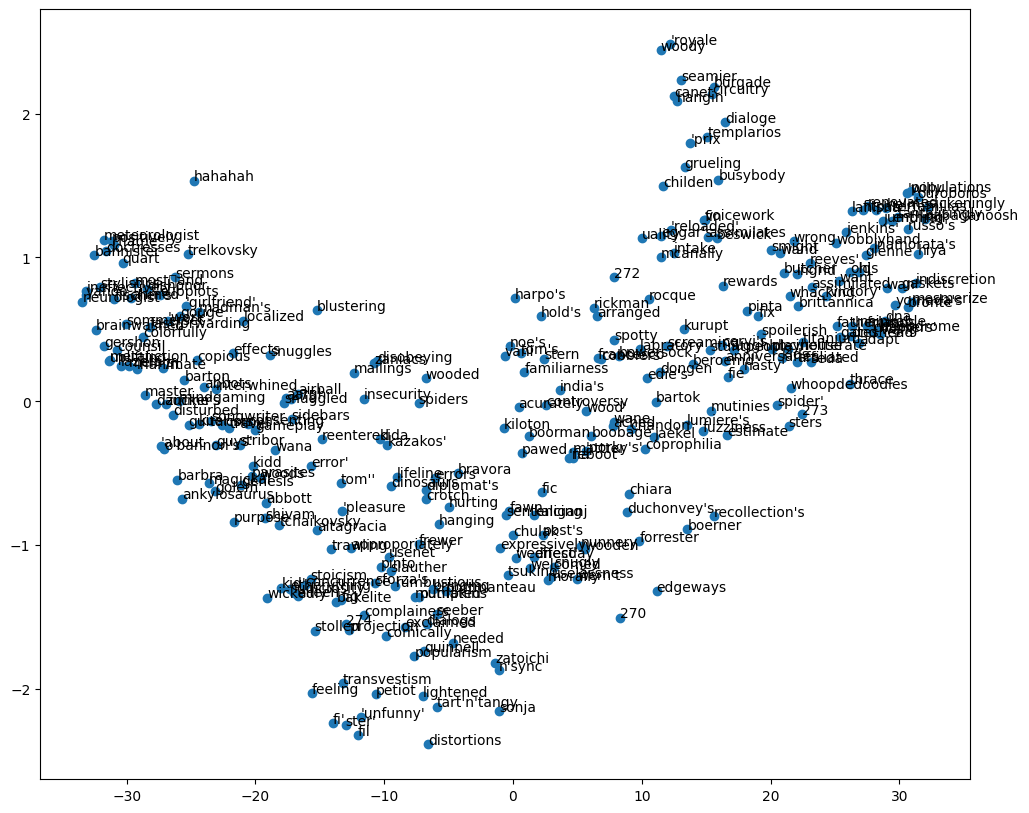

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

subset = 300  # 처음 300 단어만
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(embedding_weights[:subset])

plt.figure(figsize=(12, 10))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(list(word_index.keys())[:subset]):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]))

plt.show()

In [28]:
import numpy as np

def nearest_words(target_word, top=10):
    idx = word_index[target_word]
    target_vec = embedding_weights[idx]

    # 코사인 유사도를 계산
    sims = np.dot(embedding_weights, target_vec) / (
        np.linalg.norm(embedding_weights, axis=1) * norm(target_vec)
    )

    # 상위 10개
    nearest = sims.argsort()[::-1][1: top+1]
    return [reverse_word_index[i] for i in nearest]

nearest_words("good")


['it',
 'you',
 'when',
 'things',
 "it's",
 'add',
 'needs',
 'almost',
 'thought',
 'right']

In [29]:
target_words = ["good", "great", "wonderful", "fun",
                "bad", "terrible", "boring", "awful"]

In [30]:
ids = [word_index[w] for w in target_words]

In [31]:
embedding_weights = model.layers[0].get_weights()[0]  # (vocab_size, embedding_dim)


In [33]:
vectors = np.array([embedding_weights[i] for i in ids])


In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=0)
points = tsne.fit_transform(vectors)


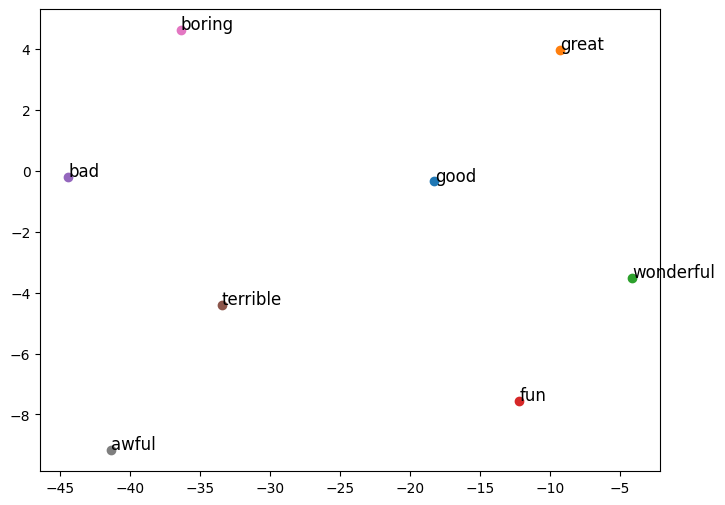

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for word, (x, y) in zip(target_words, points):
    plt.scatter(x, y)
    plt.text(x+0.02, y+0.02, word, fontsize=12)
plt.show()


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

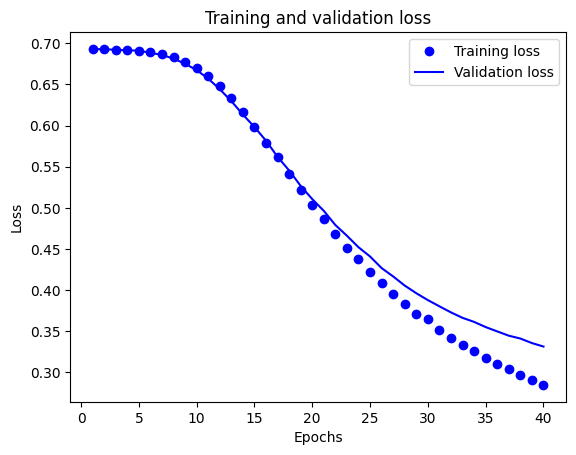

In [53]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo : 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

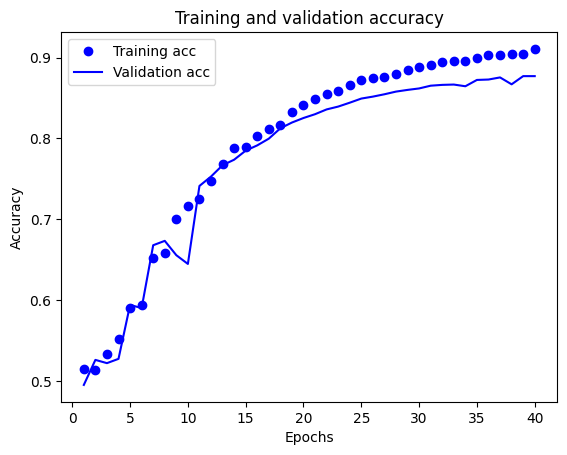

In [118]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### More on embedding example

In [119]:
from numpy import array

# define documents
docs = ['Well done!',
'Good work',
'Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50

encoded_docs = [tf.keras.preprocessing.text.one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[5, 18], [14, 28], [43, 14], [46, 28], [14], [40], [28, 14], [8, 14], [28, 28], [26, 32, 18, 30]]


In [120]:
# pad documents to a max length of 4 words
max_length = 4

padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [121]:
# define the model
embedding_model = Sequential()
embedding_model.add(keras.layers.Embedding(vocab_size, 4, input_length=max_length))
embedding_model.add(keras.layers.Flatten())
embedding_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(embedding_model.summary())


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 4, 4)              200       
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
# fit the model
embedding_model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = embedding_model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 89.999998


In [123]:
first = keras.models.Model(inputs = embedding_model.input, outputs = embedding_model.layers[0].output)

In [124]:
print(padded_docs)

[[ 5 18  0  0]
 [14 28  0  0]
 [43 14  0  0]
 [46 28  0  0]
 [14  0  0  0]
 [40  0  0  0]
 [28 14  0  0]
 [ 8 14  0  0]
 [28 28  0  0]
 [26 32 18 30]]


In [125]:
first.predict(padded_docs)

1/1 [==============================] - 0s 18ms/step


array([[[ 0.09646397,  0.07356513,  0.02208707, -0.01243161],
        [-0.0277207 ,  0.08621553, -0.00387762, -0.00065113],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597]],

       [[ 0.08188313,  0.0095627 ,  0.07290186, -0.09305233],
        [-0.07295327, -0.00103966, -0.05476551,  0.08568652],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597]],

       [[ 0.04009704,  0.08741795,  0.00173433, -0.06351241],
        [ 0.08188313,  0.0095627 ,  0.07290186, -0.09305233],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597]],

       [[ 0.04518907,  0.01530632,  0.0050627 , -0.04827546],
        [-0.07295327, -0.00103966, -0.05476551,  0.08568652],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597],
        [-0.04855411,  0.00036058,  0.08651519, -0.00430597]],



In [126]:
padded_docs[0]

array([ 5, 18,  0,  0])